# Light curves distribution analysis

Obligatory import for the notebook sake.

In [176]:
import os
import lsst.afw.geom as afwGeom
import lsst.afw.table as afwTable
import pickle

import numpy as np

import lsst.daf.persistence as dafPersist
import re
import astropy.coordinates as coord
import astropy.units as u

import matplotlib.pyplot as plt
from astropy.table import Table

File containing the Mjd dictionary. Directory definition (depending wich set of data is going to be used)

In [177]:
pkl_file = open('mjd_dict.pickle', 'rb')
mjds = pickle.load(pkl_file)


Some useful methods

In [178]:
def source_distance(src1, src2):
    ra, dec = src1['ra'], src1['dec']
    ra2, dec2 = src2['ra'], src2['dec']
            
    return np.sqrt((float(ra)-float(ra2))**2+(float(dec)-float(dec2))**2)/3.14159*180*3600


def threshold_light_curves(light_curves, threshold):
    t_light_curves = [lc for lc in light_curves if len(lc) >= threshold]
    return t_light_curves

def build_light_curve_from_snls_file(data, c):

    bandpasses = ['r']


    lightcurve = {}
    lightcurve['bandpass'] = []
    lightcurve['mjd'] = []
    lightcurve['ra'] = []
    lightcurve['dec'] = []
    lightcurve['flux'] = []
    lightcurve['flux_error'] = []
    lightcurve['zp'] = []
    lightcurve['zpsys'] = []


    for mjd, flux, error in data:

        #print 'yep',visit
        lightcurve['bandpass'].append(str('sdss' + bandpasses[0]))
        lightcurve['mjd'].append(float(mjd))
        lightcurve['ra'].append(c.ra.radian)
        lightcurve['dec'].append(c.dec.radian)
        lightcurve['flux'].append(float(flux))
        lightcurve['flux_error'].append(float(error))
        #lightcurve['flux'].append(src['base_CircularApertureFlux_12_0_flux'])
        #lightcurve['flux_error'].append(src['base_CircularApertureFlux_12_0_fluxSigma'])
        lightcurve['zp'].append(25.0)
        lightcurve['zpsys'].append('ab')

    lc = Table(data=lightcurve)
    return lc

def build_lightcurve(source_list):
    """
    Assemble a light curve data table from available files.
    """

    bandpasses = ['r']


    lightcurve = {}
    lightcurve['classification'] = []
    lightcurve['bandpass'] = []
    lightcurve['mjd'] = []
    lightcurve['ra'] = []
    lightcurve['dec'] = []
    lightcurve['flux'] = []
    lightcurve['flux_error'] = []
    lightcurve['zp'] = []
    lightcurve['zpsys'] = []


    for visit, src in source_list:

        #print 'yep',visit
        lightcurve['classification'].append(src['classification_dipole'])
        lightcurve['bandpass'].append(str('sdss' + bandpasses[0]))
        lightcurve['mjd'].append(mjds[str(visit)])
        lightcurve['ra'].append(src['coord_ra'])
        lightcurve['dec'].append(src['coord_dec'])
        lightcurve['flux'].append(src['base_CircularApertureFlux_4_5_flux'])
        lightcurve['flux_error'].append(src['base_CircularApertureFlux_4_5_fluxSigma'])
        #lightcurve['flux'].append(src['base_CircularApertureFlux_12_0_flux'])
        #lightcurve['flux_error'].append(src['base_CircularApertureFlux_12_0_fluxSigma'])
        lightcurve['zp'].append(25.0)
        lightcurve['zpsys'].append('ab')
    lightcurve = Table(data=lightcurve)
    return lightcurve


def mean_lc_flux(lc2):

    mjds = []
    m_fluxes = []
    m_error = []
    s_error = []
    i = 0
    while i < len(lc2['mjd']):
        mjd = lc2['mjd'][i]
        j = i+1
        mjds.append(int(mjd))
        m_fluxes.append(lc2['flux'][i]*lc2['flux_error'][i])
        m_error.append(lc2['flux_error'][i])
        s_error.append(lc2['flux_error'][i]**2)
        total = 1.
       
        while j<len(lc2['mjd']) and int(lc2['mjd'][j]) == int(mjd):

            m_fluxes[-1]+= lc2['flux'][j]*lc2['flux_error'][j]
            

                
            m_error[-1] += lc2['flux_error'][j]
            s_error[-1] += (lc2['flux_error'][j]**2)
            #mjds[-1] += int(lc2['mjd'][j])
            total+=1
            j+=1
            
       
        m_fluxes[-1] = np.divide(m_fluxes[-1], m_error[-1] )
        m_error[-1] = np.divide(np.sqrt(s_error[-1]), total)
        i = j

    return mjds, m_fluxes, m_error


In [179]:
def plot_object_distribution(data):
    plt.figure(figsize=(20,10))
    p = plt.bar(ind, data.values(),  align='center')
    plt.xticks(ind, data.keys())
    
    total = sum(data.values())

    for i, rect in enumerate(p):
        h = rect.get_height()
        perc = np.around(float(h)/total*100, 2)
        plt.text(rect.get_x()+ rect.get_width()/3, rect.get_height()+15, str(perc) +"% = "+  str(int(h)), fontsize=15)

    plt.show()
    
def plot_light_curve_with_tags(light_curve):
    
    plt.figure(figsize=(20,10))
    class_lc = light_curve.group_by("classification")
    indices = class_lc.groups.indices

    for i in range(1, len(indices)):
        i_start = indices[i-1] 
        i_end = indices[i]
        group = class_lc[i_start:i_end]
        marker = marker_dict[group[-1]["classification"]]
        label =  classification_dict[group[-1]["classification"]]
        plt.errorbar(group["mjd"], group["flux"],  yerr=group["flux_error"], fmt=marker, color='red', label=label, markersize=10)

    plt.legend(numpoints=1)
    #plt.ylim(ymin=0)

    plt.show()

def plot_proportion(x_data, y_data, x_data_label="x", y_data_label="y", percentual=False):
    
    plt.figure(figsize=(20,10))
    plt.scatter(x_data, y_data, 10)
    plt.xlabel(x_data_label)
    plt.ylabel(y_data_label)
    plt.xlim(xmin=-1)
    plt.ylim(ymin=-1)
    if percentual == False:
        max_n = max(max(x_data), max(y_data))+10
    else:
        max_n = 110
        plt.xticks(np.arange(0,101,10))
        plt.yticks(np.arange(0,101,10))
        plt.xlim(xmax=100)
        plt.ylim(ymax=100)
        
    plt.plot([0,max_n], [0,max_n], 'r--')
    
    for i in np.arange(0,max_n, 10):
        plt.plot([0,i], [i,0],  'r--')
    plt.grid(True)
    plt.show()
    


Light curves from SNLS are read.

06D3bz


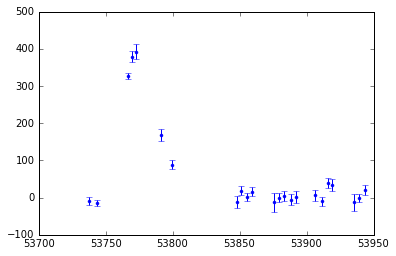

06D3cb


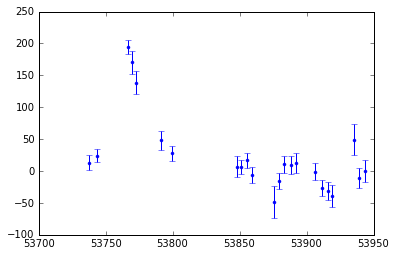

06D3cc


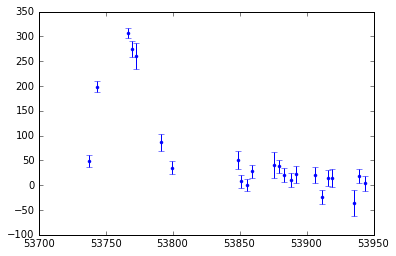

06D3cn


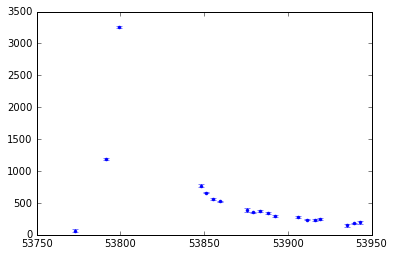

06D3df


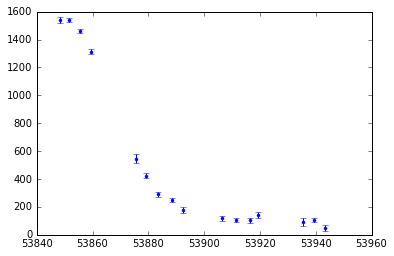

06D3dl


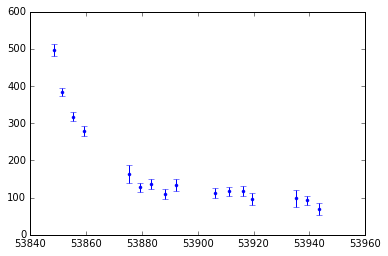

06D3do


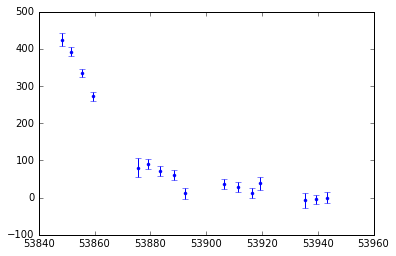

06D3dt


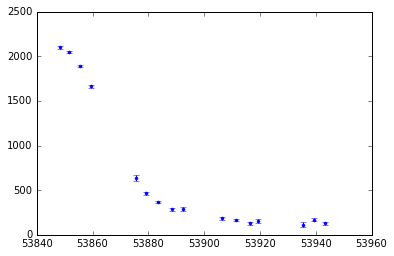

06D3ed


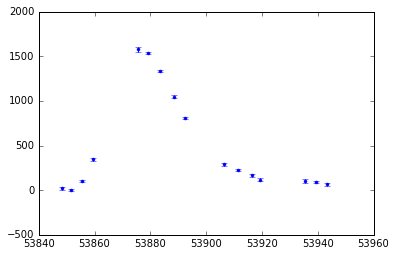

06D3el


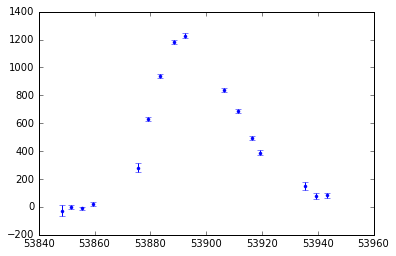

06D3em


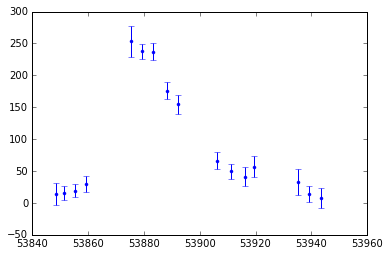

06D3en


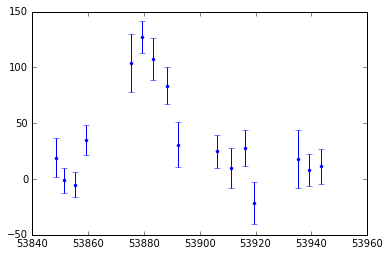

06D3et


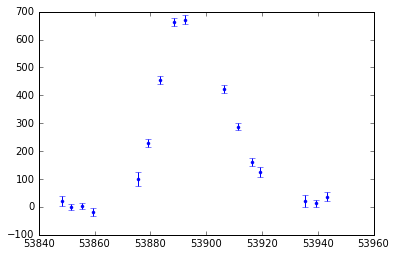

06D3fp


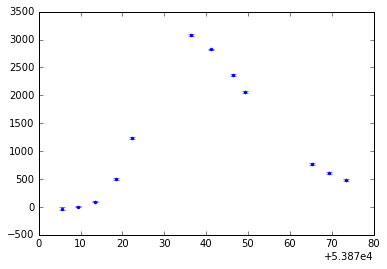

06D3gh


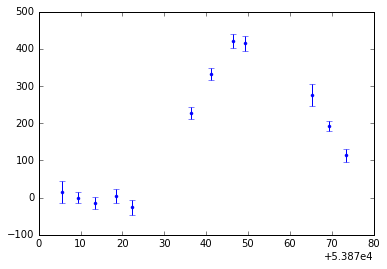

06D3gn


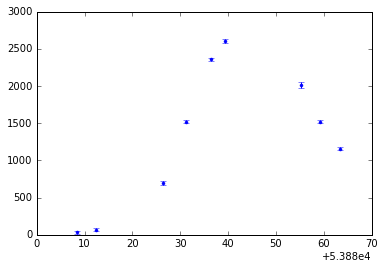

06D3gx


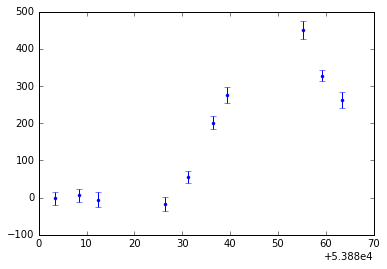

In [180]:


f = open('/renoir_data_02/jpreyes/lsst_data/sn_control/J_A+A_523_A7_table9.dat.txt','r')
data_elems = f.read()
#m = re.findall('^06D3.*?\\|(.*?)\\|', data, re.MULTILINE)
elems = re.findall('^(06D3.*?)\\|(.*?)\\|', data_elems, re.MULTILINE)

f = open('/renoir_data_02/jpreyes/lsst_data/sn_control/J_A+A_523_A7_table10.dat.txt','r')
data = f.read()


%matplotlib inline
snls_array = []
for sn in elems:
    c = coord.SkyCoord(sn[-1], unit=(u.hourangle, u.deg))
    
    m = re.findall('^'+str(sn[0])+'\\|r\\|(.*?)\\|(.*?)\\|(.*?)$', data, re.MULTILINE)

    print sn[0]
    snls_lc = build_light_curve_from_snls_file(m, c)
    plt.errorbar(snls_lc['mjd'], snls_lc['flux'], yerr=snls_lc['flux_error'], fmt='.', color='blue')
    snls_array.append(snls_lc)
    plt.show()
    
#pickle.dump(snls_array, open('/renoir_data_02/jpreyes/lsst_data/transients_files/snls_transients_filter_r.lc', 'wb'))


This method allows to create a unified catalog per visit. The twin notebook of this one performs a thresholding by removing all detections not tagged as "positive". This notebook keeps every detection with its classification.

In [181]:
import numpy as np

import lsst.daf.persistence as dafPersist
DATADIR="/renoir_data_02/jpreyes/lsst_data/CFHTLS_master/"

butler = dafPersist.Butler(DATADIR+"/output")
visits = butler.queryMetadata("deepDiff_differenceExp", format=['visit'],dataId={'filter':'r'})
visits = np.array(visits)
mask = (visits >= 836493) & (visits <= 860150)
visits =  visits[mask]
print visits, len(visits)

[836493 836494 836495 836496 836497 836498 837002 837003 837004 837005
 837006 837007 837008 838853 838854 838855 838857 838864 838865 838866
 838867 838868 839308 839309 839310 839311 839312 844210 844211 844212
 844213 844214 844230 844489 844490 844491 844492 844493 844494 844495
 844496 844497 844498 844514 844515 844516 844517 844518 844845 844846
 844847 844848 844849 845345 845346 845347 845348 845349 849373 849374
 849375 849376 849377 849685 849686 849687 849688 849689 850177 850178
 850179 850180 850181 850586 850587 850588 850589 850590 851057 851058
 851059 851060 851061 852890 852891 852892 852893 852894 853232 853233
 853234 853235 853236 853539 853540 853541 853542 853543 853727 853728
 853729 853730 853731 858537 858538 858539 858540 858541 859608 859609
 859610 859611 859612 860146 860147 860148 860149 860150] 118


In [219]:
c_files = glob.glob(in_directory+str(c_cat)+"*.fits")
print c_files

['vc_catalogs/6sigma/836497.fits']


In [252]:
in_directory = "catalogs/6sigma/"
out_directory = "nc_catalogs/6sigma/"
import lsst.afw.table as afwTable
import glob

for c_cat in visits:
    v_catalog = None
    #print "catalogs/6sigma/"+str(c_cat)+"*.fits"
    c_files = glob.glob(in_directory+str(c_cat)+"*.fits")
    
    for c_file in c_files:
        catalog = afwTable.SourceCatalog.readFits(c_file)
        
        if v_catalog is None:
            v_catalog = catalog.copy()
        else:
            v_catalog.extend(catalog)
            
    if v_catalog is not None:
        
        v_catalog.writeFits(out_directory+"/"+c_files[0].split("/")[-1].split("-")[0]+".fits")

In [282]:
in_directory = "catalogs/6sigma/"

count = []
for c_cat in visits:
    v_catalog = None
    #print "catalogs/6sigma/"+str(c_cat)+"*.fits"
    c_files = glob.glob(in_directory+str(c_cat)+"*.fits")
    count.append(c_files)


Multimatch function is used to create the light curves

In [261]:
in_directory = "catalogs/6sigma/"
out_directory = "nc_catalogs/6sigma/"
import lsst.afw.table as afwTable
import glob

multi_matches = None

for c_cat in visits:
    v_catalog = None
    #print "catalogs/6sigma/"+str(c_cat)+"*.fits"
    c_files = glob.glob(in_directory+str(c_cat)+"*.fits")
    
    for c_file in c_files:
        catalog = afwTable.SourceCatalog.readFits(c_file)
        
        if multi_matches is None and len(catalog)>0:
            multi_matches = afwTable.MultiMatch(catalog[0].schema, {'visit':int}, radius=afwGeom.Angle(1./3600., afwGeom.degrees))
        if multi_matches is not None:
            multi_matches.add(catalog, {'visit':int(c_files[0].split("/")[-1].split("-")[0])})
            
    
results = multi_matches.finish(removeAmbiguous=False)  

In [303]:
directory = "catalogs/6sigma/"
files = os.listdir(directory)

multi_matches = None
for f in files:
    

    catalog = afwTable.SourceCatalog.readFits(directory+"/"+f)
    
    if multi_matches is None and len(catalog)>0:
        multi_matches = afwTable.MultiMatch(catalog[0].schema, {'visit':int}, radius=afwGeom.Angle(1./3600., afwGeom.degrees))
    if multi_matches is not None:
        multi_matches.add(catalog, {'visit':int(f.split("-")[0])})
    
results = multi_matches.finish(removeAmbiguous=False)

In [304]:
print len(results)

745932


In [291]:
for r in results:
    if r['object'] == 8:
        print r['visit'], r["base_CircularApertureFlux_4_5_flux"]
    if r['object'] == 9:
        break

837002 -1660.02783203


Light curves are thresholded using the total number of points belonging to the curve.

In [305]:
light_curves = []
i = 0
current = -1
while i < len(results):
    result = results[i]
    if current == -1 or current != result['object']:
        lc = [(result['visit'],result)]
        light_curves.append(lc)
        current = result['object']
    else:
        light_curves[-1].append((result['visit'],result))
    i+=1

t_light_curves = threshold_light_curves(light_curves, 10)
print len(t_light_curves)

10639


In [306]:
count = 0
for t_l in t_light_curves:
    storage = []
    for v, s in t_l:
        storage.append((v, s["base_CircularApertureFlux_4_5_fluxSigma"]))
    if len(t_l) != len(set(storage)):
        count += 1

In [307]:
print count

0


In [273]:
l_c = t_light_curves[7]
for v, p in l_c:
    print v, p["base_CircularApertureFlux_4_5_flux"]

837002 -1037.83703613
844210 120.460746765
858538 607.140258789


SNcosmo Light curve objects are created in this step.

In [308]:
#lc = build_lightcurve(t_light_curves[4])
lcs = []
for t_light_curve in t_light_curves:
    lcs.append(build_lightcurve(t_light_curve))

In [309]:
count = 0
for t_l in lcs:
    storage = []
    for point in t_l:
        storage.append((point["mjd"], point["flux"]))
    if len(t_l) != len(set(storage)):
        count += 1

In [310]:
count

0

This method informs the match percentage with SNLS data.

In [311]:

matches = []
for sn in elems:
    
    match = False
    c = coord.SkyCoord(sn[-1], unit=(u.hourangle, u.deg))
    
    
    for i, lc in enumerate(lcs):
        #print lc[0]['ra']
        #print lc[0]['dec']
        if source_distance(lc[0], {'ra':c.ra.radian, 'dec':c.dec.radian}) < 2:
            match = True
 
            matches.append((sn[0], i))
            break
    
        #print 'no match'
print 'found ' + str(float(len(matches))/float(len(elems))) 

found 0.411764705882


Some dictionaries are created in order to visualize the light curves composition

In [312]:
props = {}

for lc in lcs:
    for point in lc:
        if props.has_key(point['classification']) == False:
            props[point['classification']] = 1
        else:
            props[point['classification']]+=1
            

            
classification_dict = {0:"Dipole type I", 1: "Dipole type II", 3:"Fringe", 4: "Artifact", 5:"Negative", 6:"Positive", 7:"Point Positive"}
marker_dict = {0:"x", 1: "x", 3:"^", 4: ".", 5:"v", 6:"*", 7:"."}

for key in classification_dict.keys():
    if props.has_key(key) == True:
        props[classification_dict[key]] = props.pop(key)

Composition percentage per category

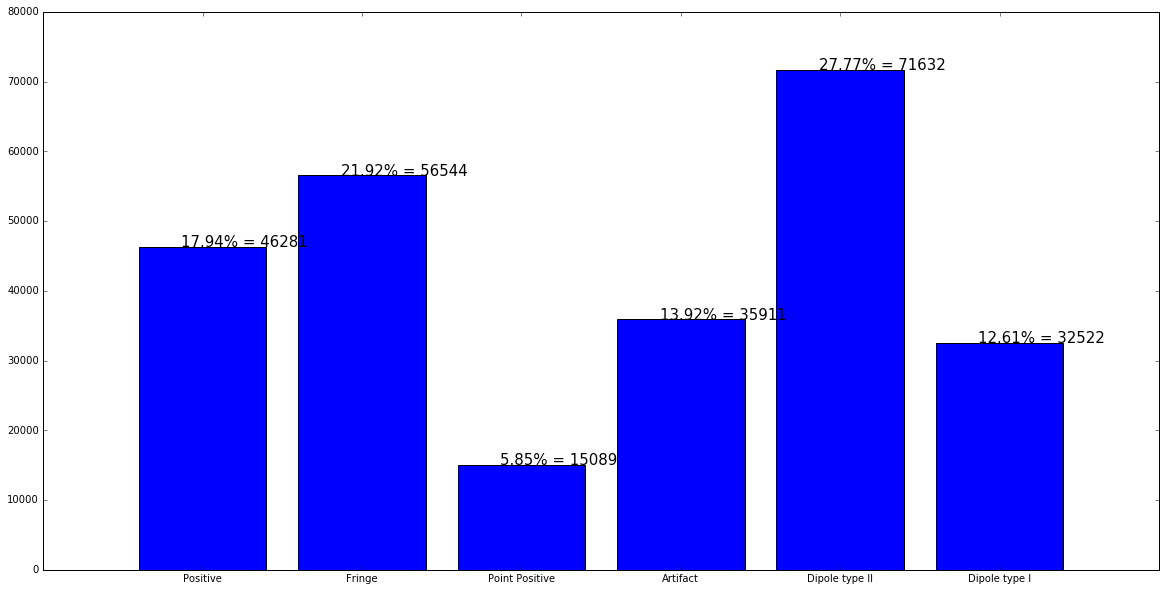

In [313]:
plot_object_distribution(props)

code for light curve visualization, while showing the different tags for each detection.

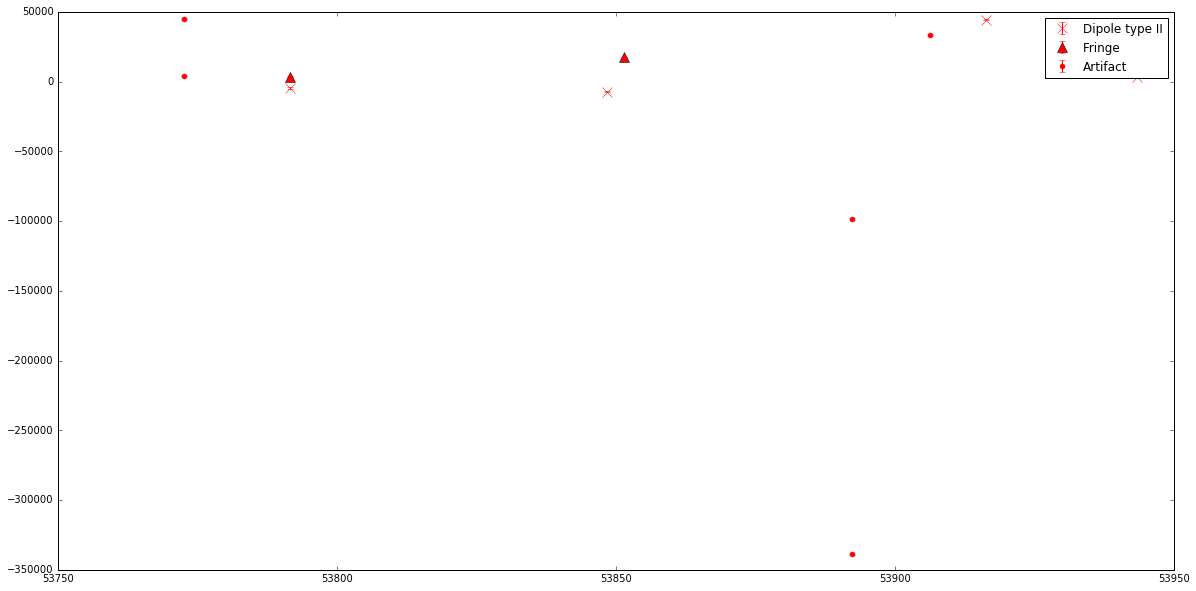

In [314]:
lc = lcs[7]
plot_light_curve_with_tags(lc)

In [315]:
classification_dict = {0:"Dipole type I", 1: "Dipole type II", 3:"Fringe", 4: "Artifact", 5:"Negative", 6:"Positive", 7:"Point Positive"}
freq_dict = {0:[], 1:[], 3:[], 4:[], 5:[], 6:[], 7:[]}

In [316]:
freq_dict = {0:[], 1:[], 3:[], 4:[], 5:[], 6:[], 7:[]}
keys = freq_dict.keys()
for lc in lcs:
    class_lc = lc.group_by("classification")
    indices = class_lc.groups.indices
   
    for key in keys:
        freq_dict[key].append(0)
    
    for i in range(1, len(indices)):

        i_start = indices[i-1] 
        i_end = indices[i]
        group = class_lc[i_start:i_end]
        

            
        freq_dict[group[-1]["classification"]][-1]=len(group)
        



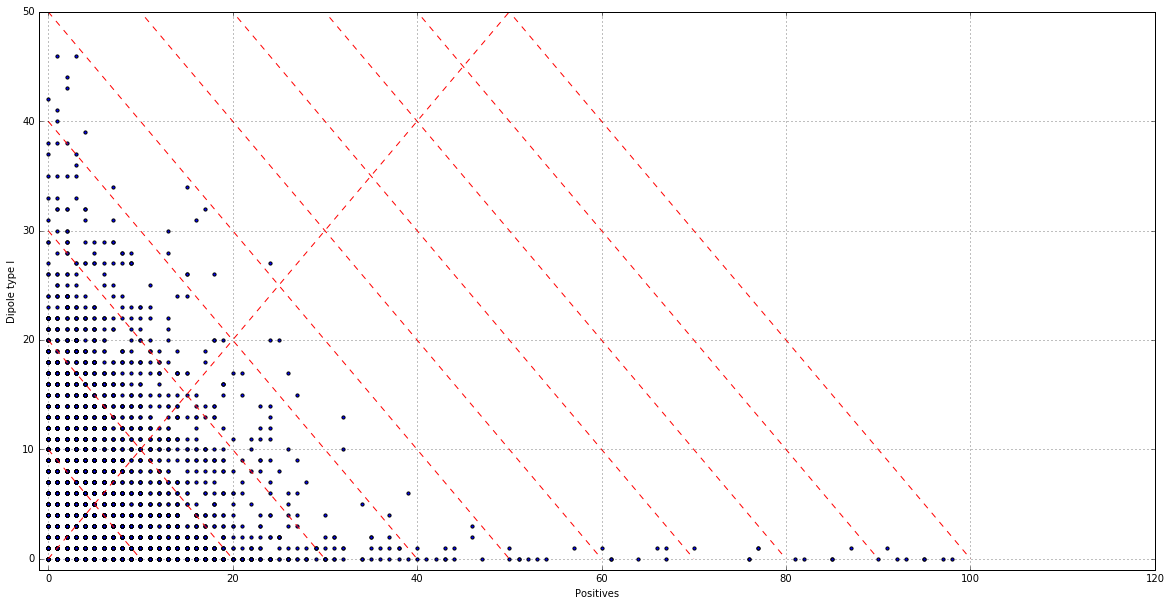

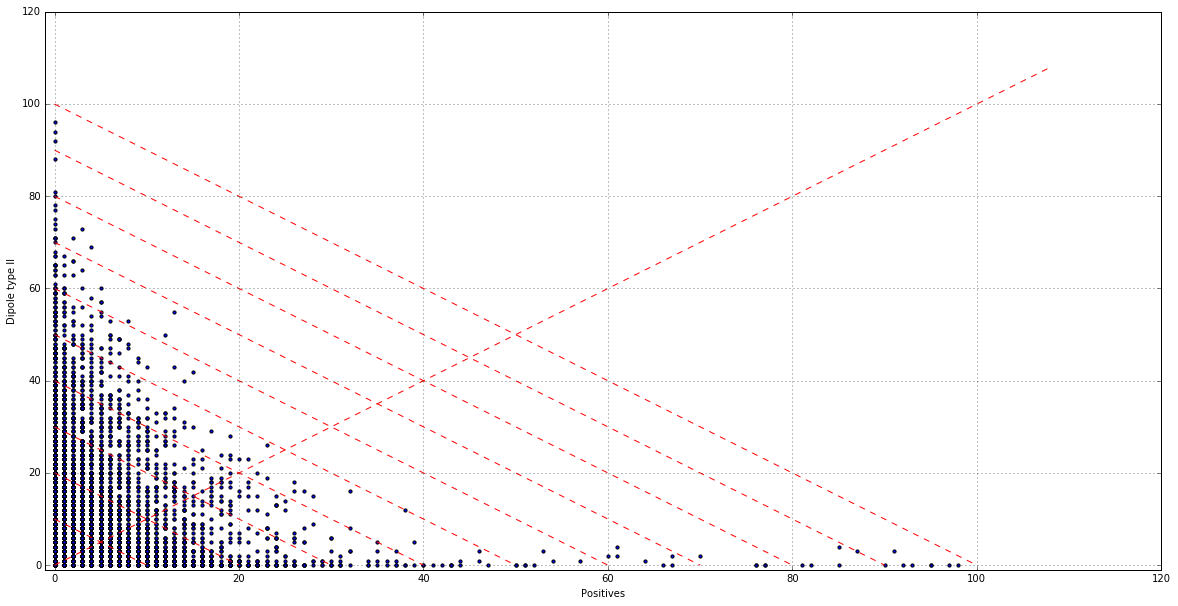

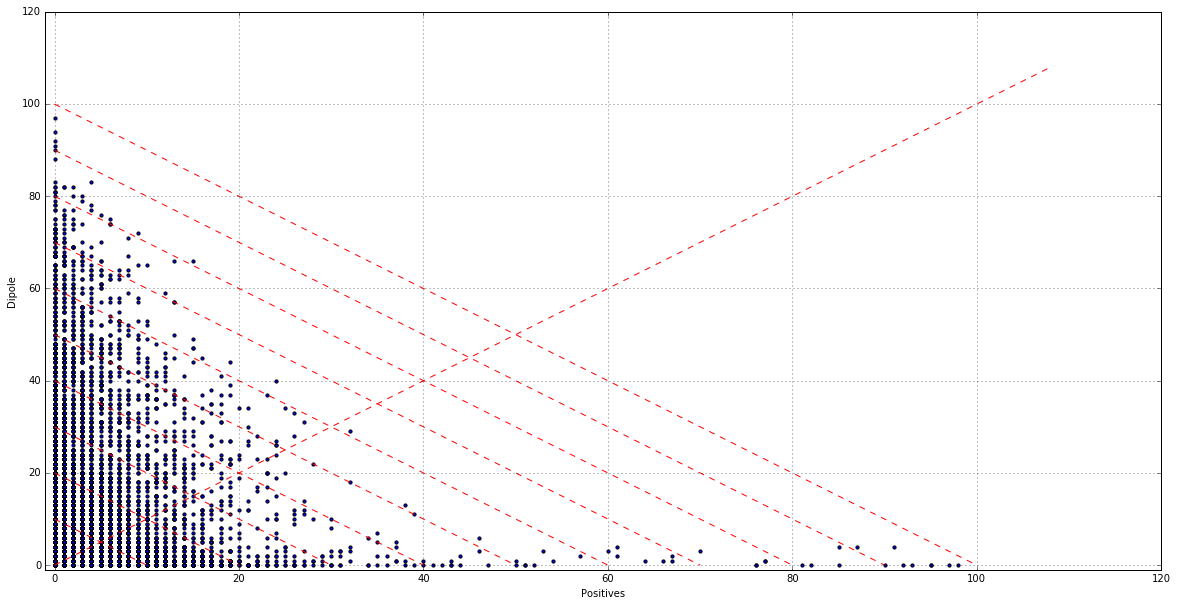

In [317]:
plot_proportion(freq_dict[6], freq_dict[0], "Positives", "Dipole type I")
plot_proportion(freq_dict[6], freq_dict[1], "Positives", "Dipole type II")
tot_dipoles = np.array(freq_dict[0])+np.array(freq_dict[1])
plot_proportion(freq_dict[6], tot_dipoles, "Positives", "Dipole")

In [318]:
freq_dict = {0:[], 1:[], 3:[], 4:[], 5:[], 6:[], 7:[]}
keys = freq_dict.keys()
for lc in lcs:
    class_lc = lc.group_by("classification")
    indices = class_lc.groups.indices
   
    for key in keys:
        freq_dict[key].append(0)
    
    for i in range(1, len(indices)):

        i_start = indices[i-1] 
        i_end = indices[i]
        group = class_lc[i_start:i_end]
        

            
        freq_dict[group[-1]["classification"]][-1]=float(len(group))/len(lc)*100
        

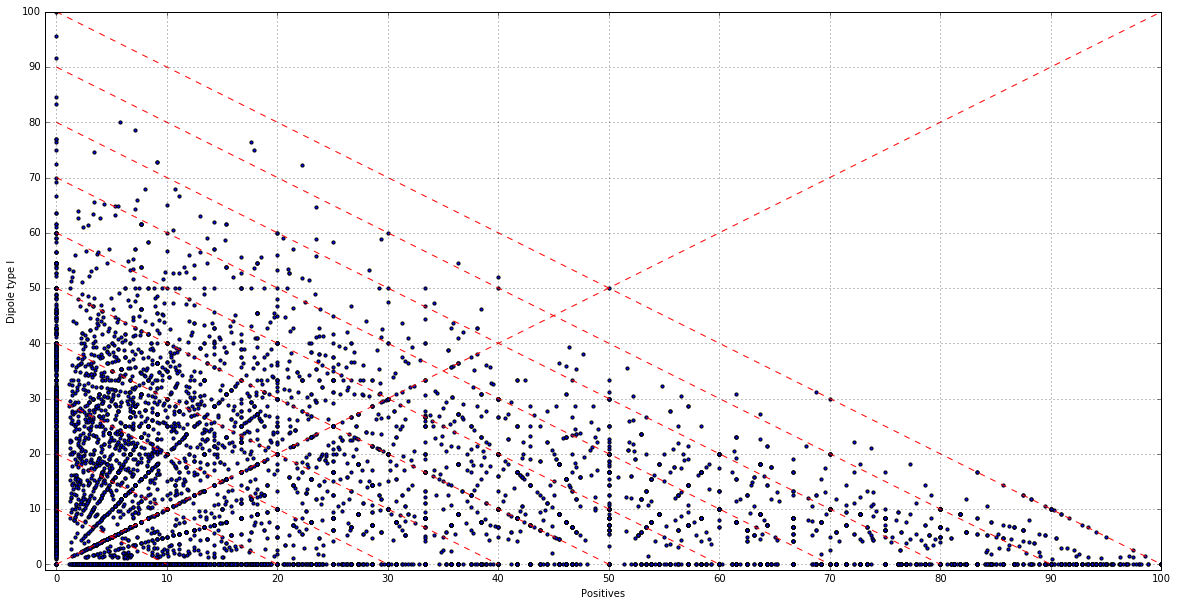

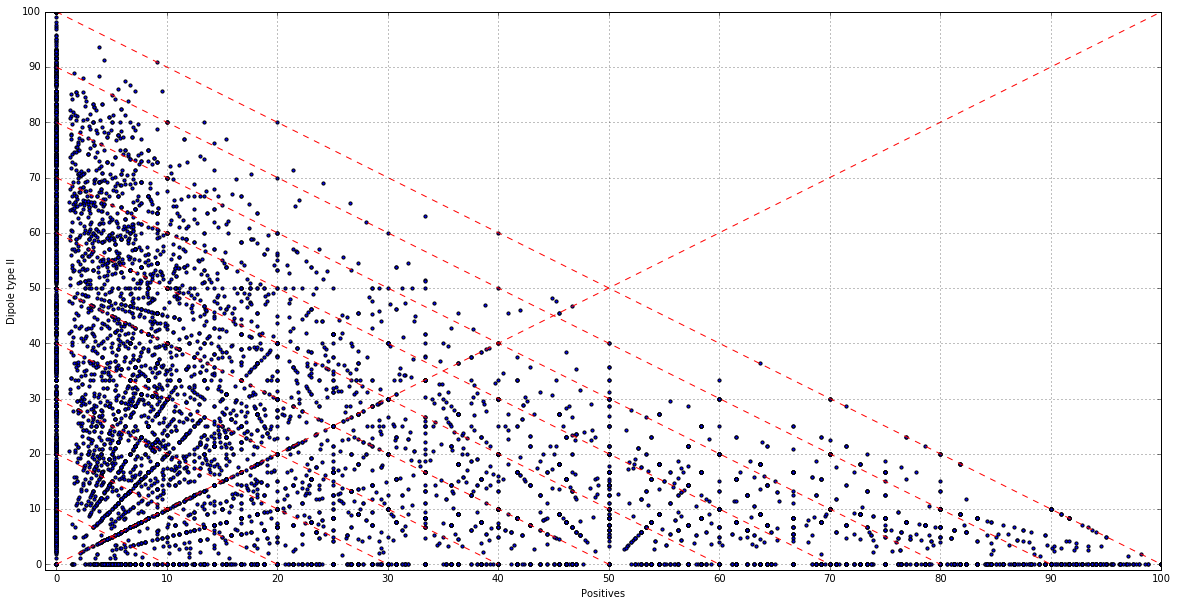

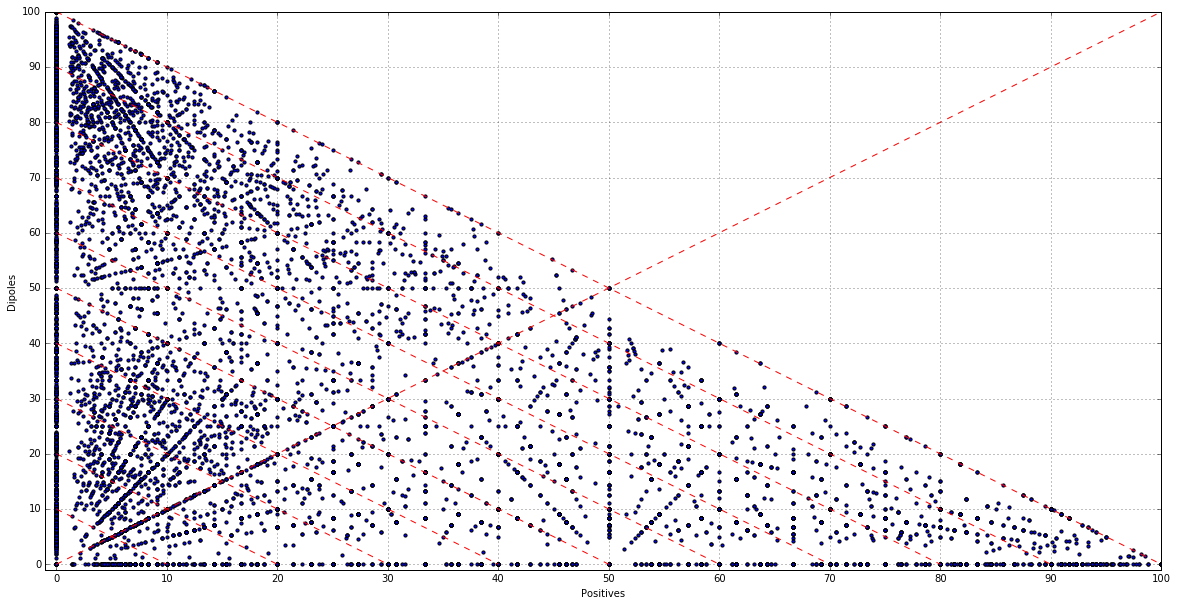

In [319]:
plot_proportion(freq_dict[6], freq_dict[0], "Positives", "Dipole type I", percentual = True)
plot_proportion(freq_dict[6], freq_dict[1], "Positives", "Dipole type II", percentual = True)
tot_dipoles = np.array(freq_dict[0])+np.array(freq_dict[1])
plot_proportion(freq_dict[6], tot_dipoles, "Positives", "Dipoles" , percentual = True)

# Light curves with 50% or more positive detections

In [320]:
mostly_pos = []
for lc in lcs:
    total = len(lc)
    req = lc['classification']==6
    pos = lc[req]
    if len(pos)/float(total) > 0.5:
        mostly_pos.append(lc)

In [321]:
props = {}

for lc in mostly_pos:
    for point in lc:
        if props.has_key(point['classification']) == False:
            props[point['classification']] = 1
        else:
            props[point['classification']]+=1
            
for key in classification_dict.keys():
    if props.has_key(key) == True:
        props[classification_dict[key]] = props.pop(key)

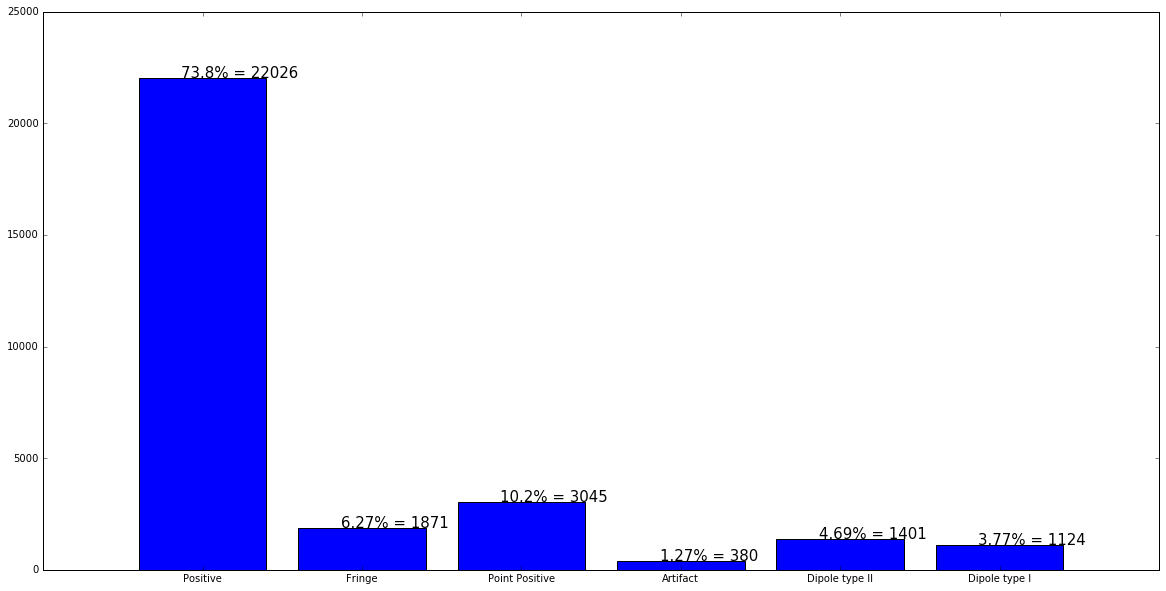

In [322]:
plot_object_distribution(props)

In [323]:
freq_dict = {0:[], 1:[], 3:[], 4:[], 5:[], 6:[], 7:[]}
keys = freq_dict.keys()
for lc in mostly_pos:
    class_lc = lc.group_by("classification")
    indices = class_lc.groups.indices
   
    for key in keys:
        freq_dict[key].append(0)
    
    for i in range(1, len(indices)):

        i_start = indices[i-1] 
        i_end = indices[i]
        group = class_lc[i_start:i_end]
        

            
        freq_dict[group[-1]["classification"]][-1]=len(group)



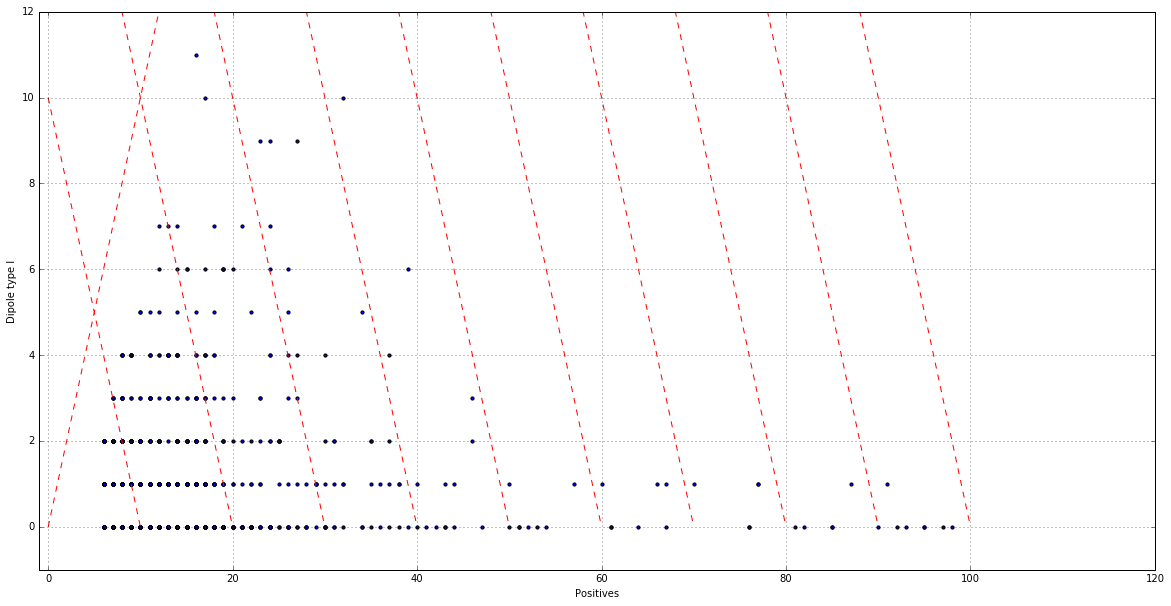

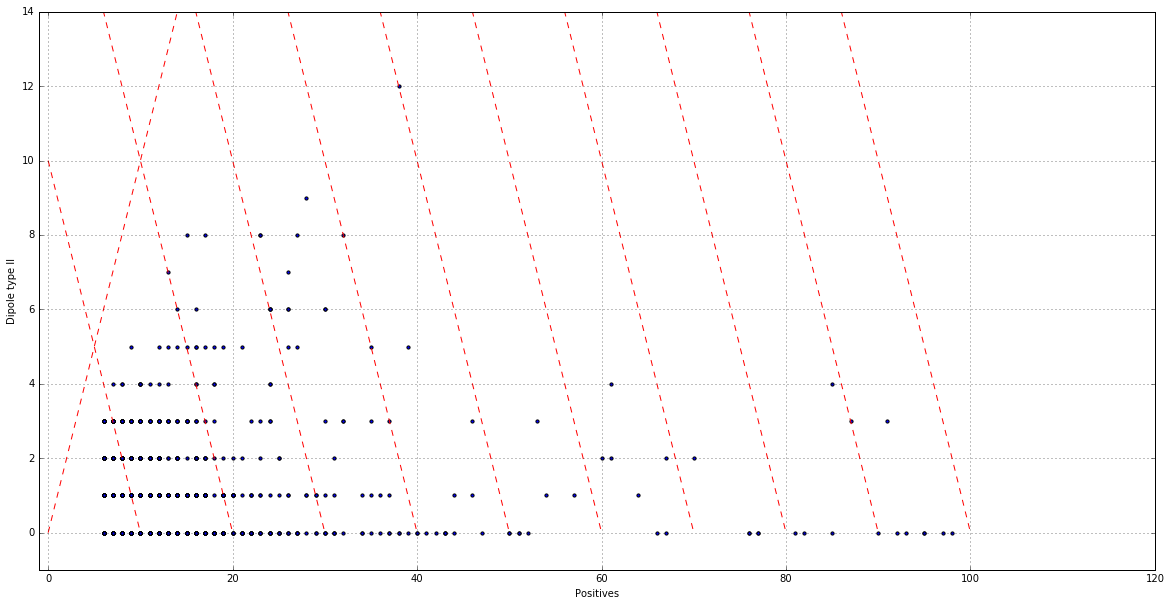

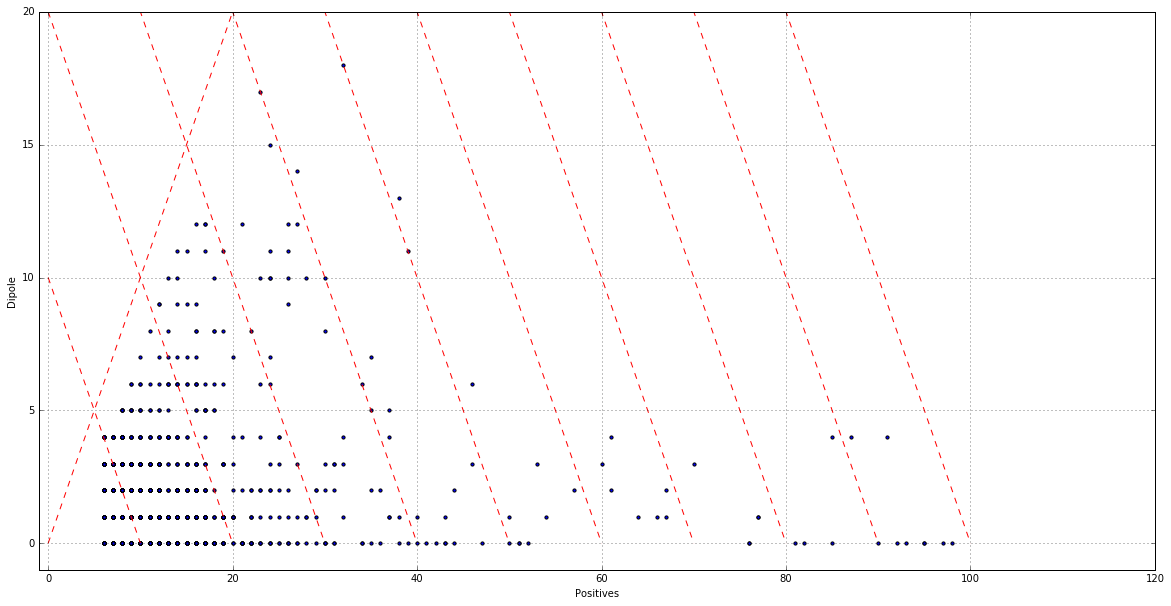

In [324]:
plot_proportion(freq_dict[6], freq_dict[0], "Positives", "Dipole type I")
plot_proportion(freq_dict[6], freq_dict[1], "Positives", "Dipole type II")
tot_dipoles = np.array(freq_dict[0])+np.array(freq_dict[1])
plot_proportion(freq_dict[6], tot_dipoles, "Positives", "Dipole")

In [325]:
freq_dict = {0:[], 1:[], 3:[], 4:[], 5:[], 6:[], 7:[]}
keys = freq_dict.keys()

for lc in mostly_pos:
    class_lc = lc.group_by("classification")
    indices = class_lc.groups.indices
   
    for key in keys:
        freq_dict[key].append(0)
    
    for i in range(1, len(indices)):

        i_start = indices[i-1] 
        i_end = indices[i]
        group = class_lc[i_start:i_end]
        

            
        freq_dict[group[-1]["classification"]][-1]=float(len(group))/len(lc)*100
        

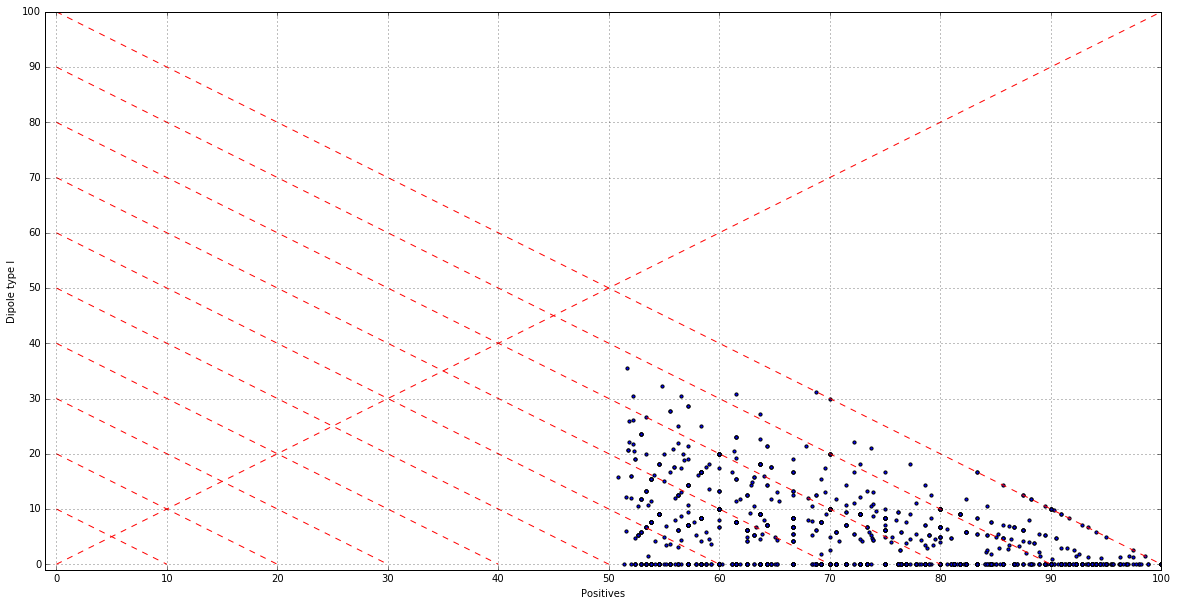

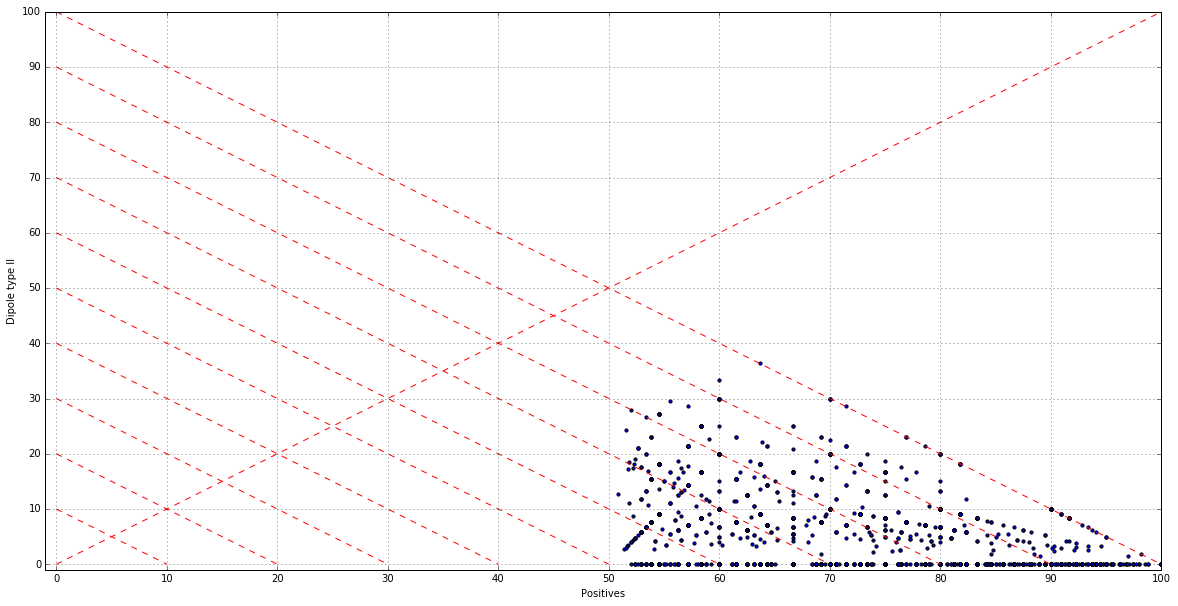

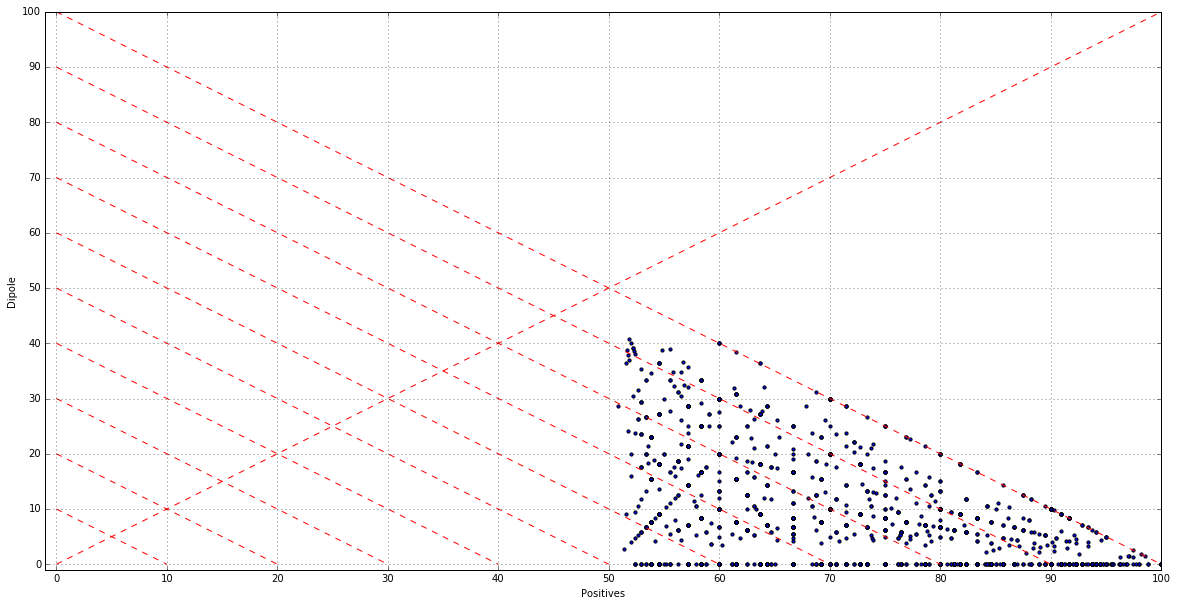

In [326]:
plot_proportion(freq_dict[6], freq_dict[0], "Positives", "Dipole type I", percentual=True)
plot_proportion(freq_dict[6], freq_dict[1], "Positives", "Dipole type II", percentual=True)
tot_dipoles = np.array(freq_dict[0])+np.array(freq_dict[1])
plot_proportion(freq_dict[6], tot_dipoles, "Positives", "Dipole", percentual=True)

# Transient candidates within 15 days

In [327]:
short_transients = []
for lc in lcs:
    mjds = lc["mjd"]
    if np.std(mjds) < 15:
        short_transients.append(lc)
        


In [328]:
print len(short_transients)

61


In [329]:
props = {}

for lc in short_transients:
    for point in lc:
        if props.has_key(point['classification']) == False:
            props[point['classification']] = 1
        else:
            props[point['classification']]+=1
            
for key in classification_dict.keys():
    if props.has_key(key) == True:
        props[classification_dict[key]] = props.pop(key)

total = 0
for key in props.keys():
    total += props[key]



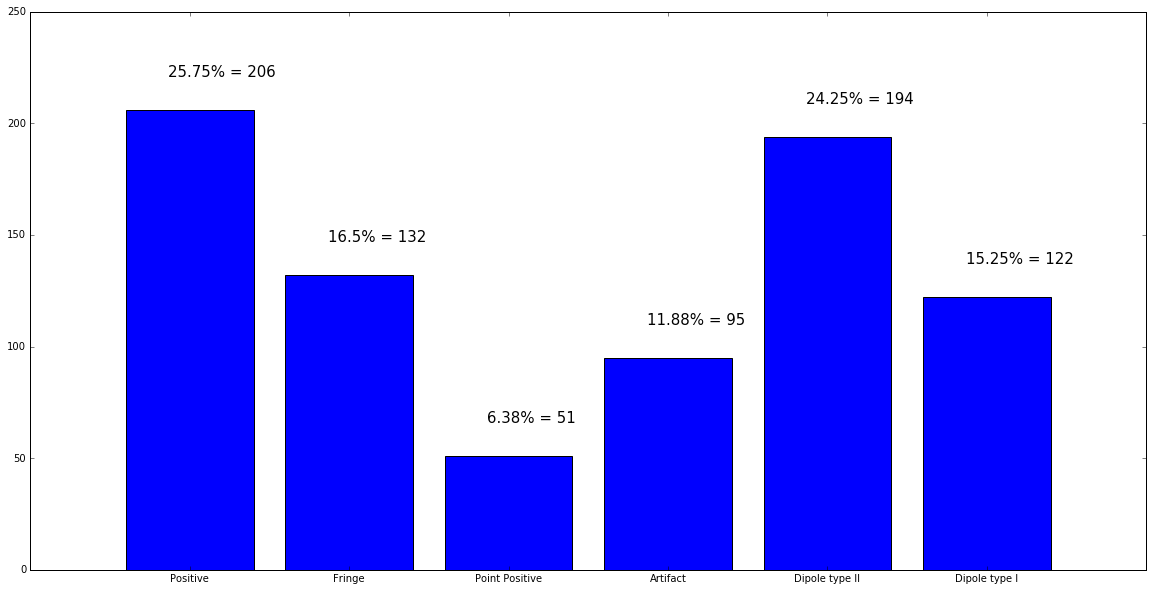

In [330]:
plot_object_distribution(props)

In [331]:
freq_dict = {0:[], 1:[], 3:[], 4:[], 5:[], 6:[], 7:[]}
keys = freq_dict.keys()
for lc in short_transients:
    class_lc = lc.group_by("classification")
    indices = class_lc.groups.indices
   
    for key in keys:
        freq_dict[key].append(0)
    
    for i in range(1, len(indices)):

        i_start = indices[i-1] 
        i_end = indices[i]
        group = class_lc[i_start:i_end]
        

            
        freq_dict[group[-1]["classification"]][-1]=len(group)

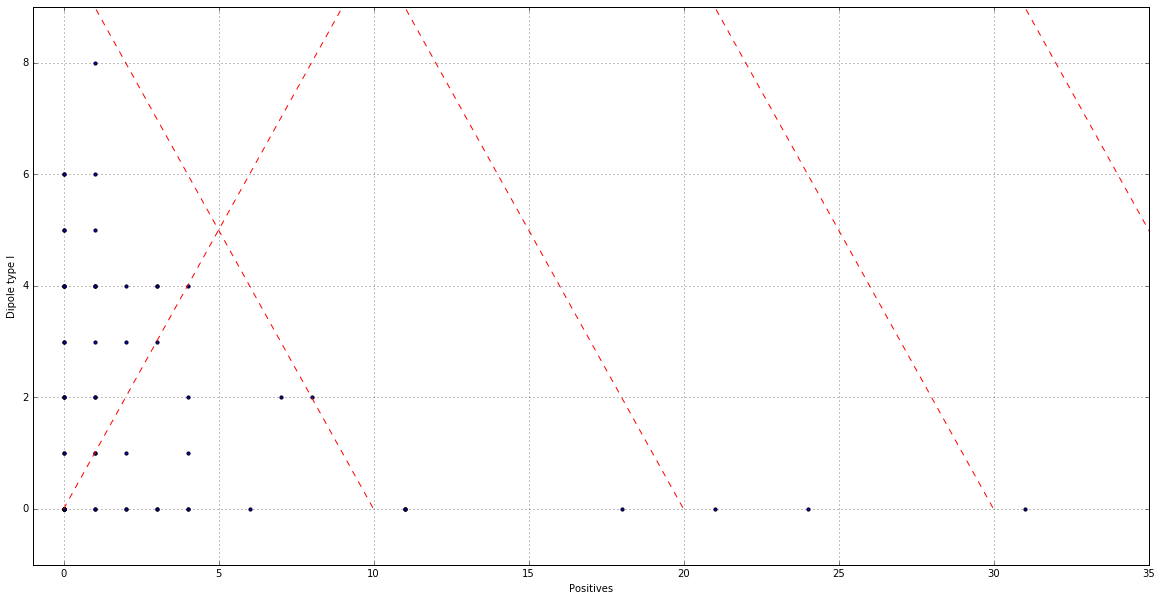

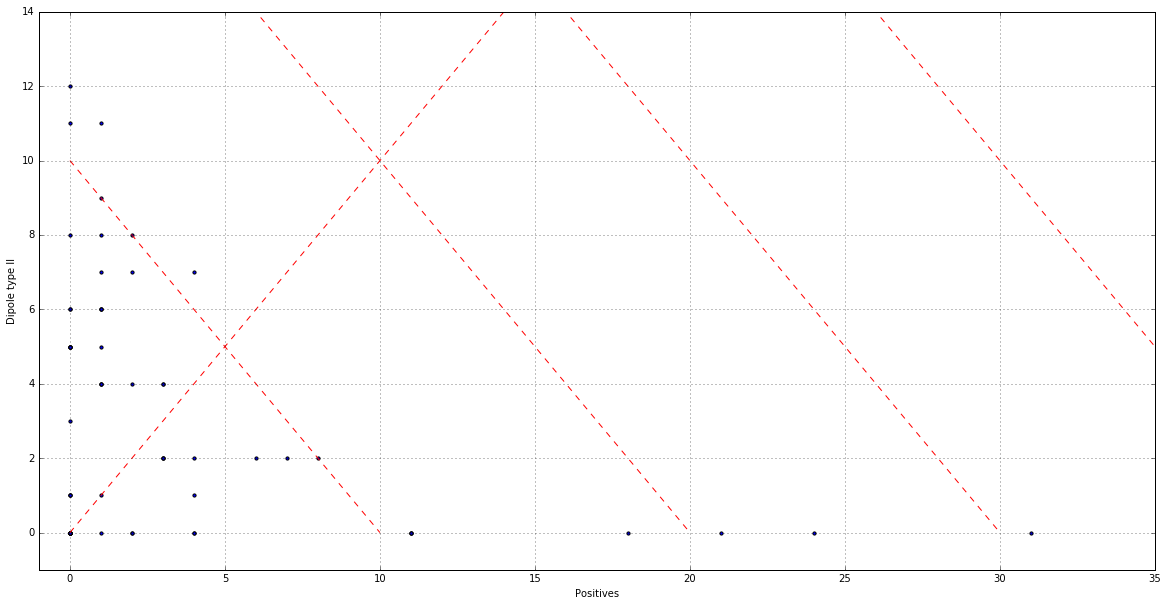

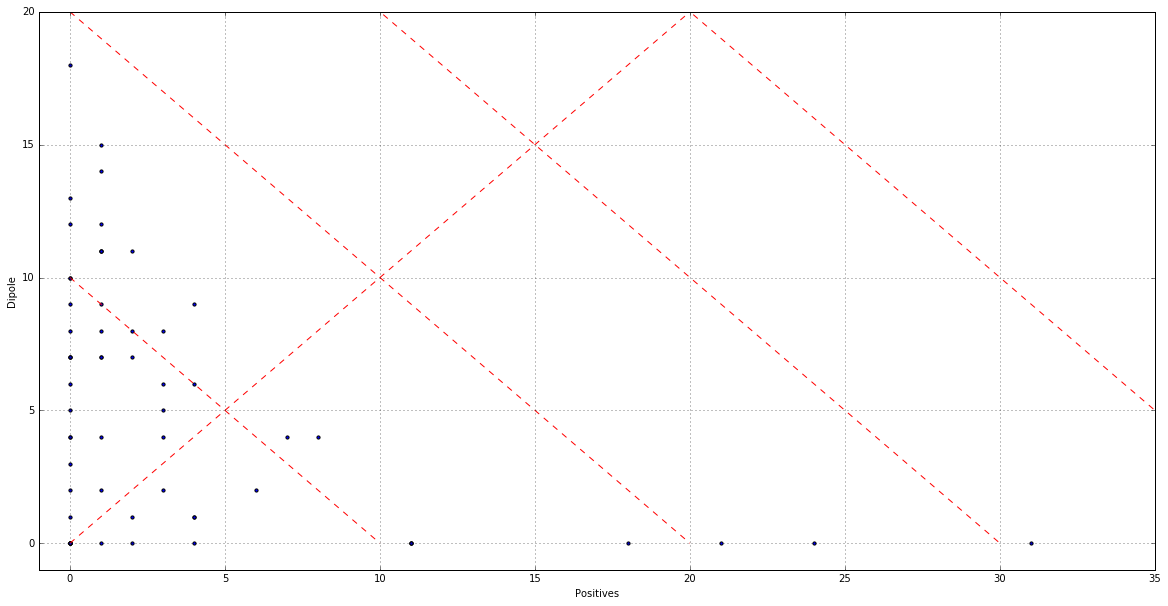

In [332]:
plot_proportion(freq_dict[6], freq_dict[0], "Positives", "Dipole type I")
plot_proportion(freq_dict[6], freq_dict[1], "Positives", "Dipole type II")
tot_dipoles = np.array(freq_dict[0])+np.array(freq_dict[1])
plot_proportion(freq_dict[6], tot_dipoles, "Positives", "Dipole")

In [333]:
freq_dict = {0:[], 1:[], 3:[], 4:[], 5:[], 6:[], 7:[]}
keys = freq_dict.keys()
for lc in short_transients:
    class_lc = lc.group_by("classification")
    indices = class_lc.groups.indices
   
    for key in keys:
        freq_dict[key].append(0)
    
    for i in range(1, len(indices)):

        i_start = indices[i-1] 
        i_end = indices[i]
        group = class_lc[i_start:i_end]
        

            
        freq_dict[group[-1]["classification"]][-1]=float(len(group))/len(lc)*100

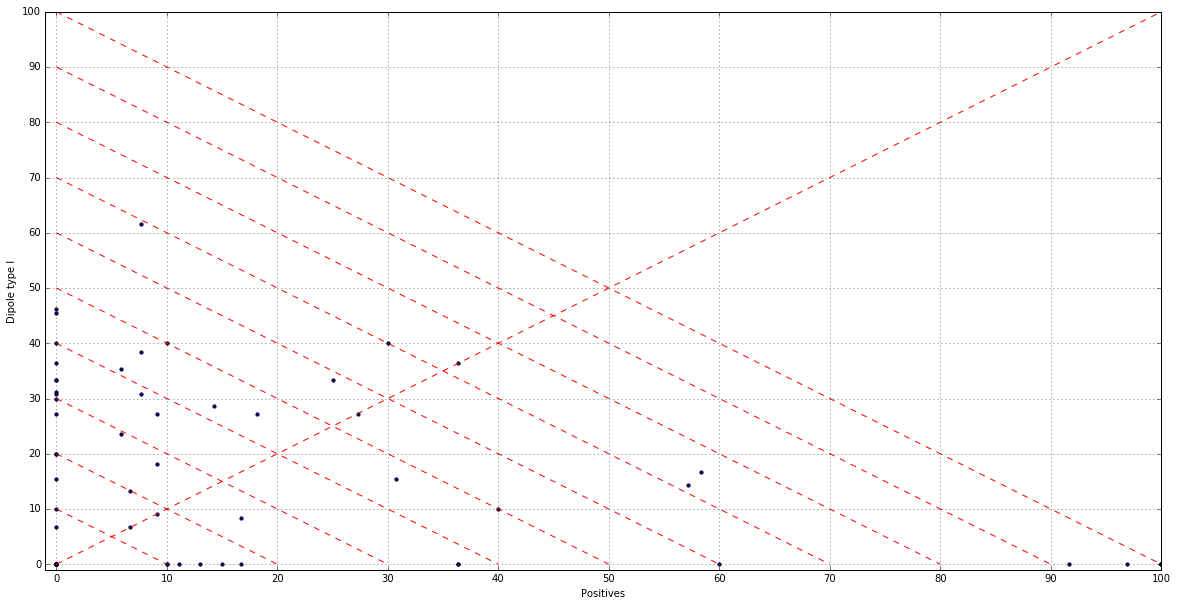

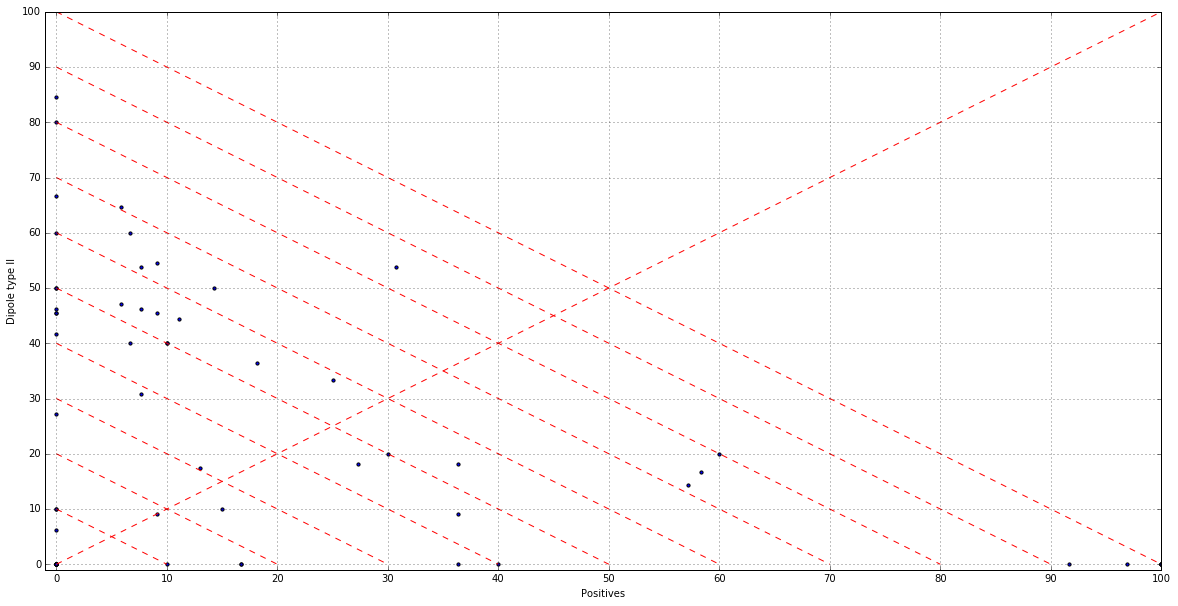

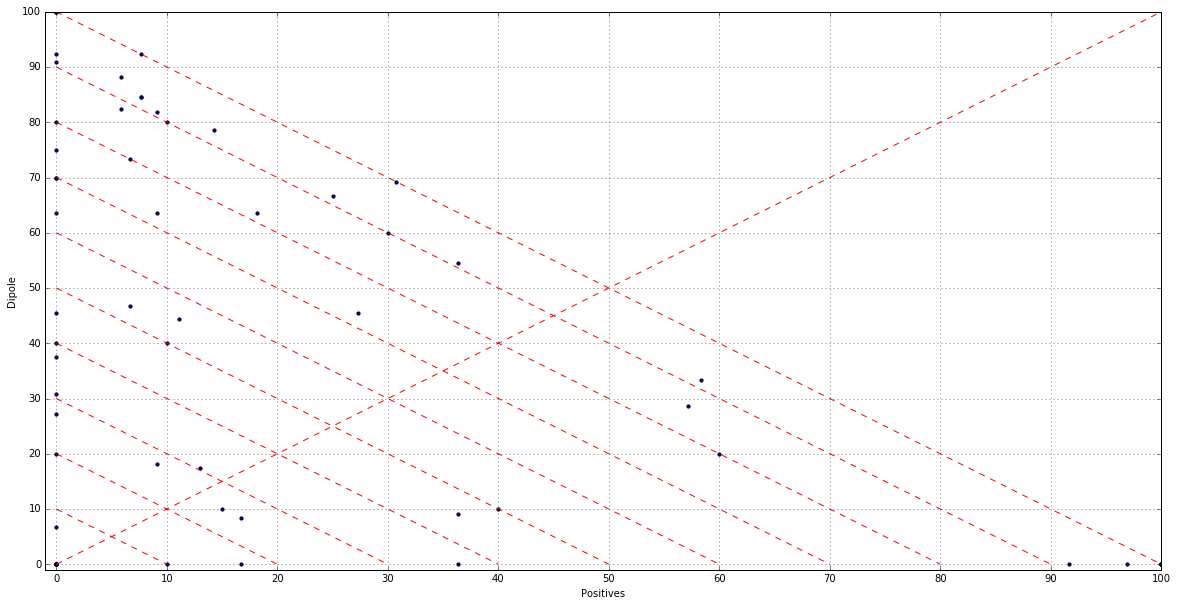

In [334]:
plot_proportion(freq_dict[6], freq_dict[0], "Positives", "Dipole type I", percentual=True)
plot_proportion(freq_dict[6], freq_dict[1], "Positives", "Dipole type II", percentual=True)
tot_dipoles = np.array(freq_dict[0])+np.array(freq_dict[1])
plot_proportion(freq_dict[6], tot_dipoles, "Positives", "Dipole", percentual=True)

# Frequencies


In [335]:
pos_frequency = []
for lc in lcs:
    req = lc['classification']==6
    pos = lc[req]
    pos_frequency.append(len(pos))

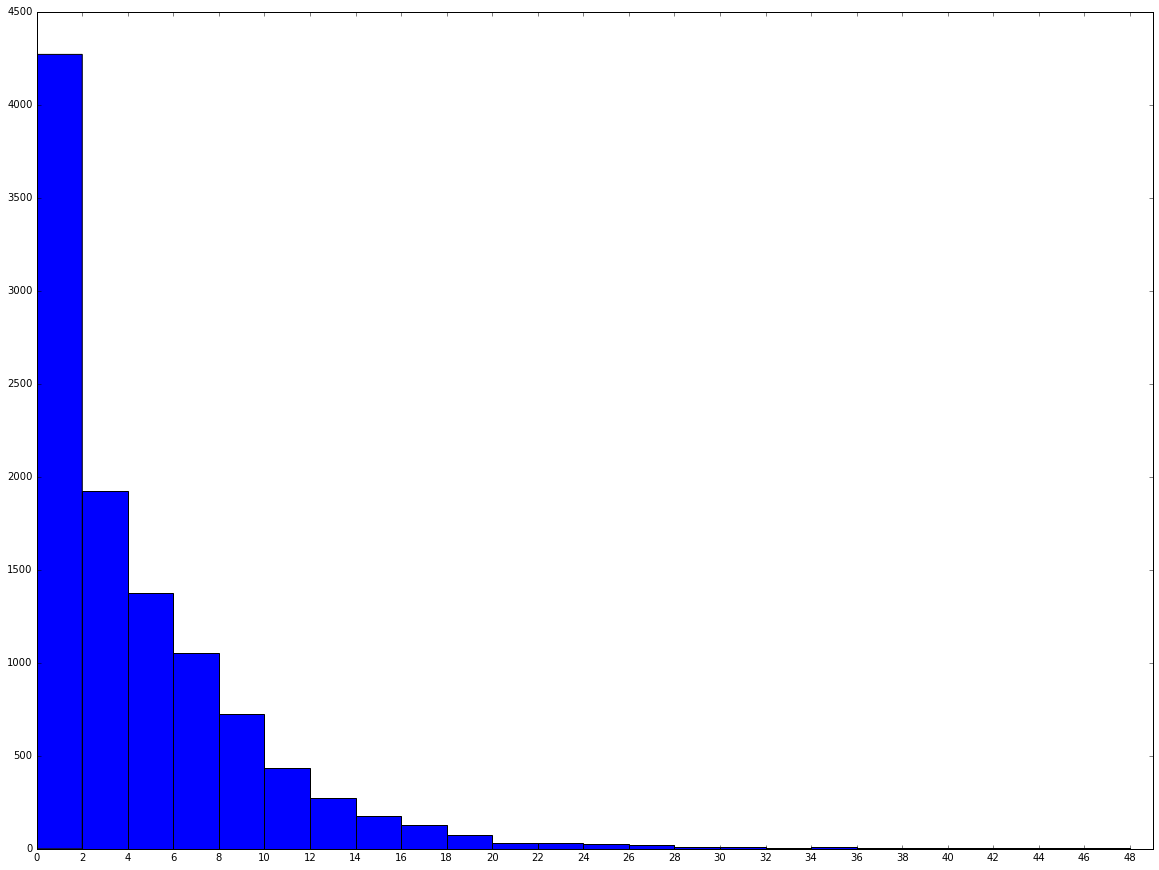

In [336]:
plt.figure(figsize=(20,15))
plt.hist(pos_frequency, range=(0,max(pos_frequency)), bins = max(pos_frequency)/2)
plt.xticks(np.arange(0,max(pos_frequency),2))
plt.xlim(xmax=max(pos_frequency)/2)
plt.show()

# Objects persisting in time

In [337]:
long_transients = []
for lc in lcs:
    mjds = lc["mjd"]
    if np.std(mjds) > 30:
        long_transients.append(lc)
        
print len(long_transients)

9383


In [338]:
props = {}

for lc in short_transients:
    for point in lc:
        if props.has_key(point['classification']) == False:
            props[point['classification']] = 1
        else:
            props[point['classification']]+=1
            
for key in classification_dict.keys():
    if props.has_key(key) == True:
        props[classification_dict[key]] = props.pop(key)

total = 0
for key in props.keys():
    total += props[key]

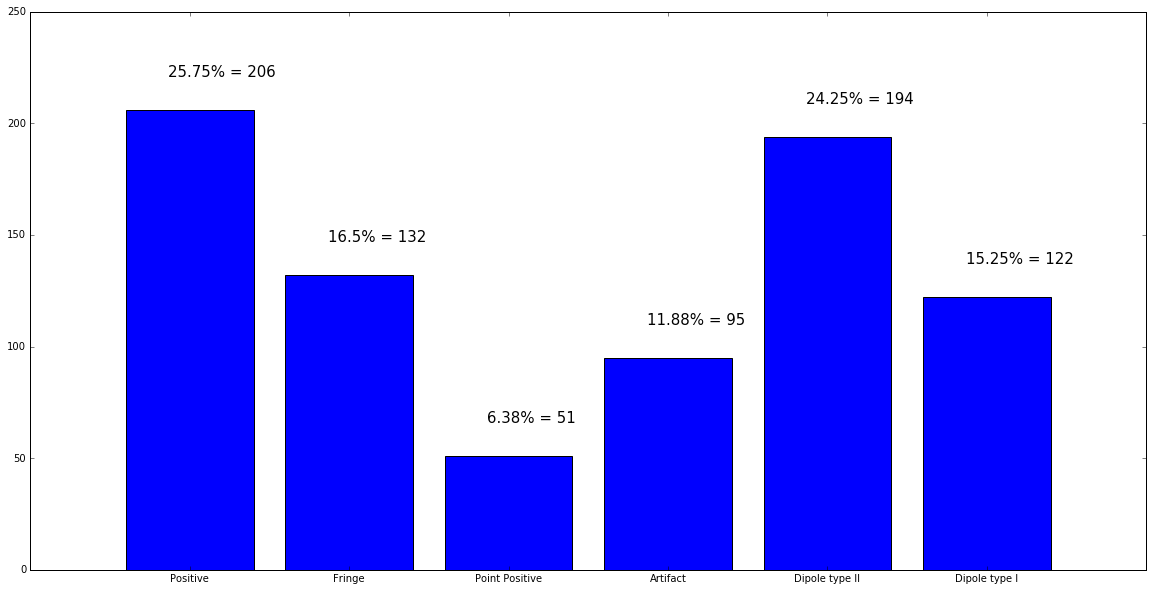

In [339]:
plot_object_distribution(props)

In [340]:
freq_dict = {0:[], 1:[], 3:[], 4:[], 5:[], 6:[], 7:[]}
keys = freq_dict.keys()
for lc in long_transients:
    class_lc = lc.group_by("classification")
    indices = class_lc.groups.indices
   
    for key in keys:
        freq_dict[key].append(0)
    
    for i in range(1, len(indices)):

        i_start = indices[i-1] 
        i_end = indices[i]
        group = class_lc[i_start:i_end]
        

            
        freq_dict[group[-1]["classification"]][-1]=len(group)
        

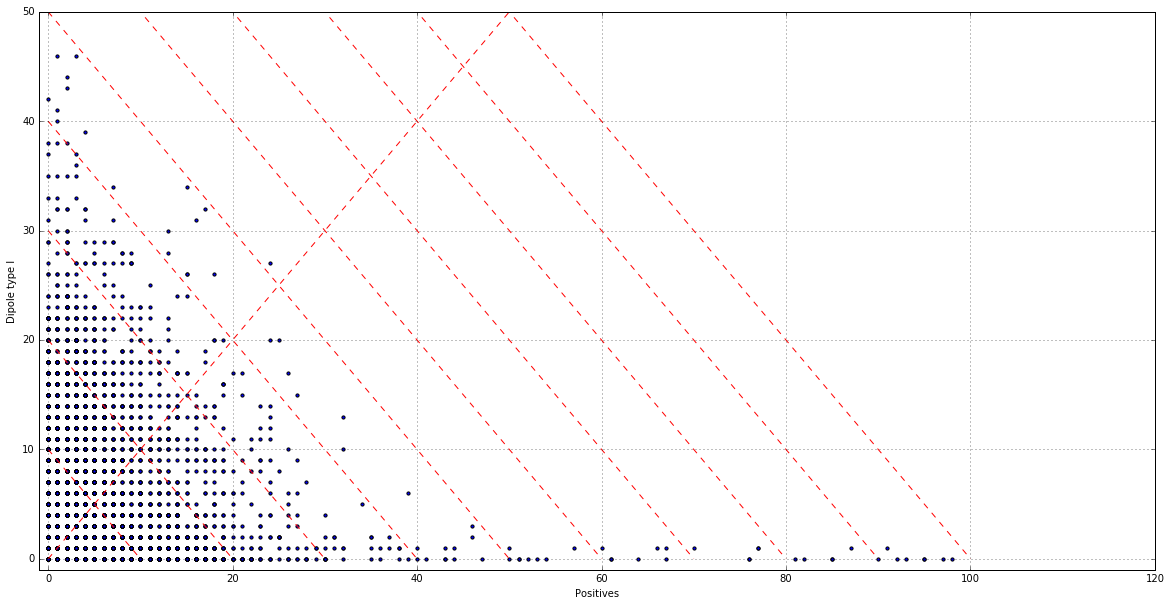

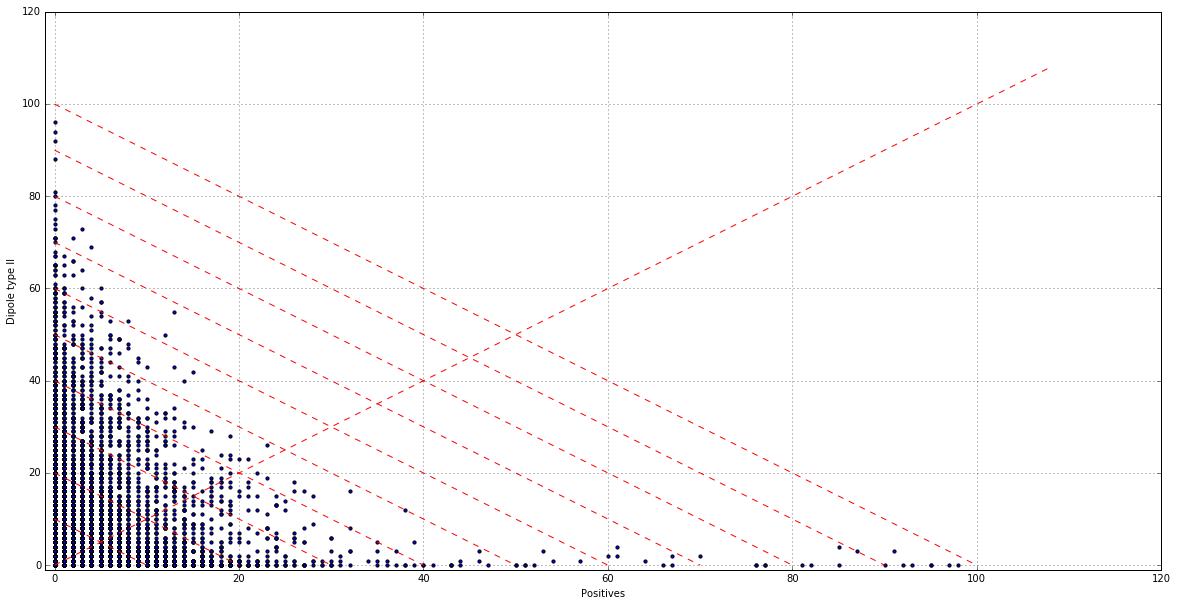

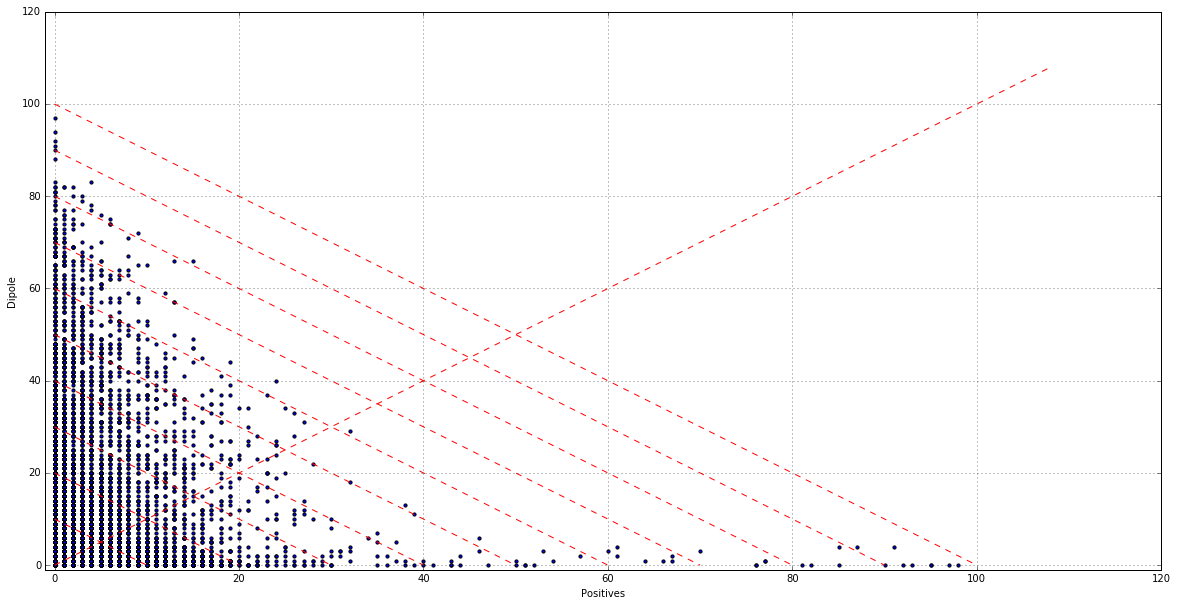

In [341]:
plot_proportion(freq_dict[6], freq_dict[0], "Positives", "Dipole type I")
plot_proportion(freq_dict[6], freq_dict[1], "Positives", "Dipole type II")
tot_dipoles = np.array(freq_dict[0])+np.array(freq_dict[1])
plot_proportion(freq_dict[6], tot_dipoles, "Positives", "Dipole")

In [342]:
freq_dict = {0:[], 1:[], 3:[], 4:[], 5:[], 6:[], 7:[]}
keys = freq_dict.keys()
for lc in long_transients:
    class_lc = lc.group_by("classification")
    indices = class_lc.groups.indices
   
    for key in keys:
        freq_dict[key].append(0)
    
    for i in range(1, len(indices)):

        i_start = indices[i-1] 
        i_end = indices[i]
        group = class_lc[i_start:i_end]
        

            
        freq_dict[group[-1]["classification"]][-1]=float(len(group))/len(lc)*100
        

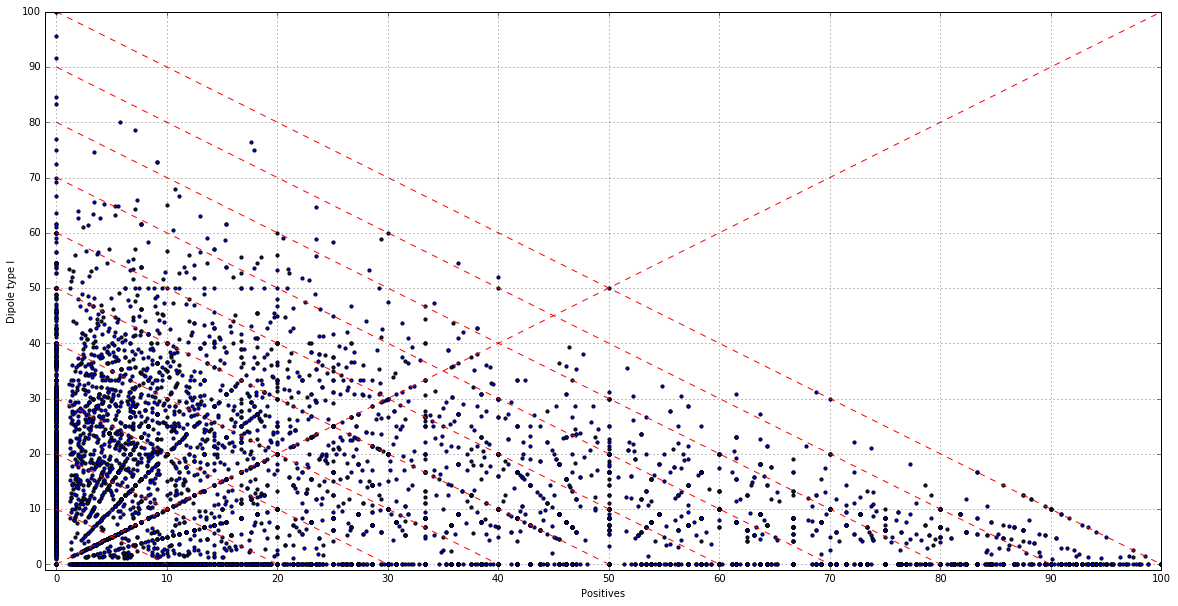

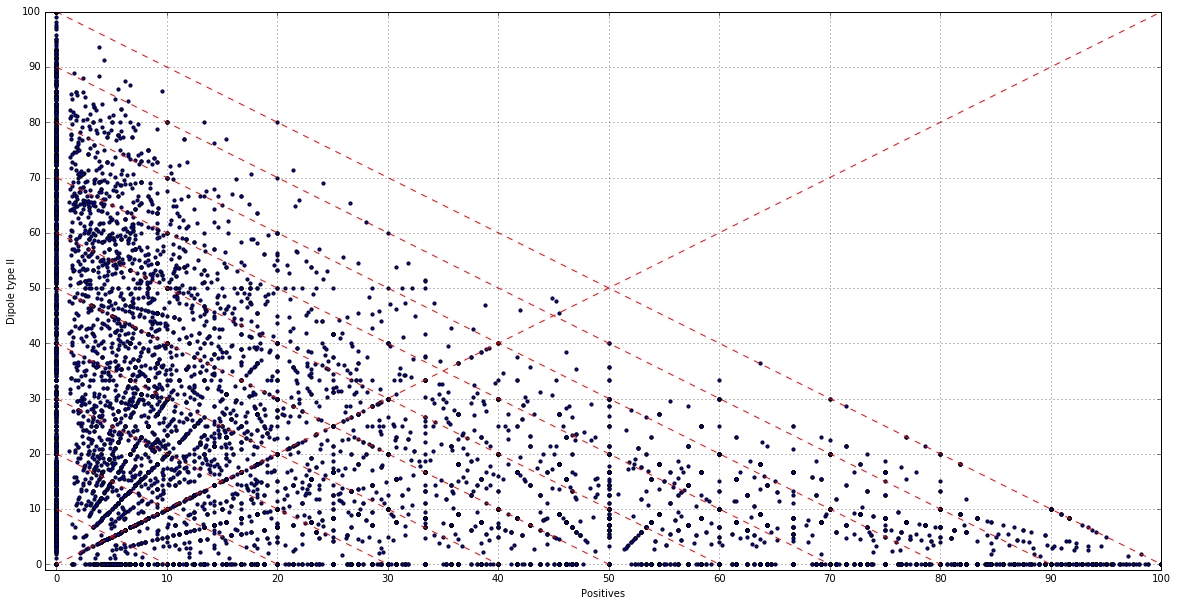

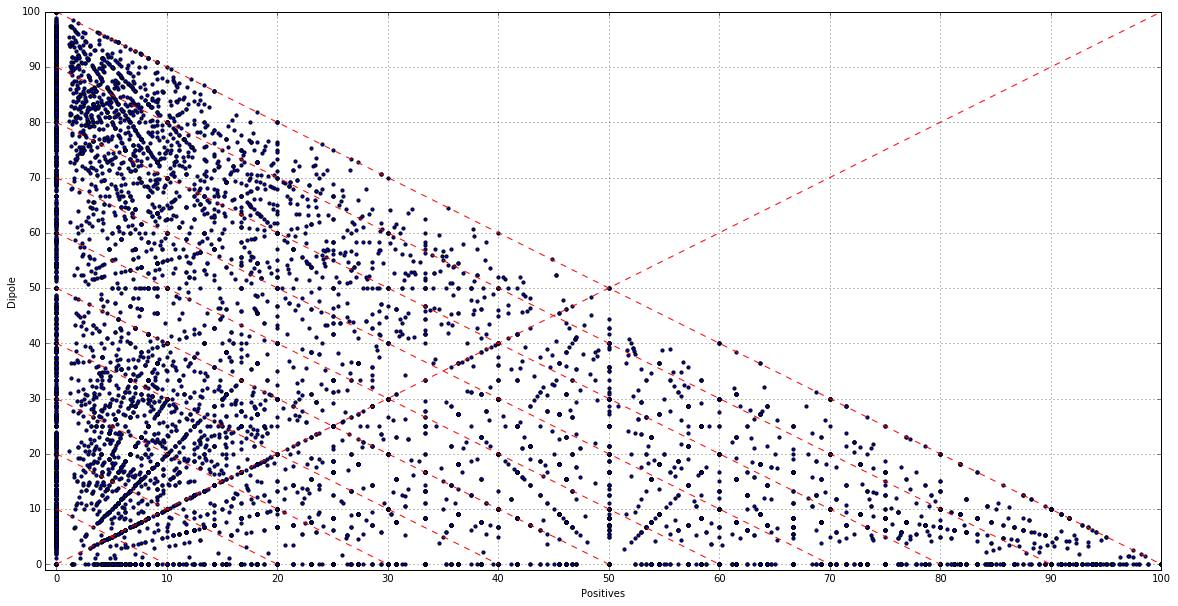

In [343]:
plot_proportion(freq_dict[6], freq_dict[0], "Positives", "Dipole type I", percentual=True)
plot_proportion(freq_dict[6], freq_dict[1], "Positives", "Dipole type II", percentual=True)
tot_dipoles = np.array(freq_dict[0])+np.array(freq_dict[1])
plot_proportion(freq_dict[6], tot_dipoles, "Positives", "Dipole", percentual=True)